In [85]:
import sys
# syspath = 'D:/Research_CAE/MyTinyCUDANN/tiny-cuda-nn/my_job'
syspath = 'D:/Research_CAE/MyTinyCUDANN/tiny-cuda-nn/main'
sys.path.append(syspath)
from my_tiny_cuda import my_MLP,my_sin,weights_init_uniform,grad1
from my_tiny_cuda import my_rmse,plot_diff,plot_result_ele,my_relativeL2,my_sig,plot_result_node
from my_tiny_cuda import my_encoding_linear as my_encoding
from my_tiny_cuda import fdiff1 as fdiff

from tools import random_points_1D,random_points_2D
# from Scale_cpp import compute_scale_cpp
import commentjson as json
import tinycudann as tcnn

import os
import torch
from torch.autograd import grad
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib.colors as colors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_dtype = torch.float32
with open(os.path.join(syspath,"config_hash.json")) as f:
    config = json.load(f)

In [86]:
class var_energy(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def f(self,x,y):
        result = torch.exp(-x)*(x-2+y**3+6*y)
        return result
    def forward(self,X,u,du_dx,du_dy):
        x,y = X[:,0],X[:,1]
        result = 1/2*(du_dx**2 + du_dy**2) + self.f(x,y)*u
        return result

class BC_function(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        x,y = X[:,0],X[:,1]
        result = torch.exp(-x)*(x+y**3)
        return result
true_func = BC_function()

In [87]:
n_levels = 16
p_l_s = 1.12
n_features = 2
base_res = 16
spectral_norm = True
# spectral_norm = False
config["encoding"]["n_levels"] = n_levels
# config["encoding"]["log2_hashmap_size"] = log2_hashmap_size
config["encoding"]["n_features_per_level"] = n_features
config["encoding"]["per_level_scale"]=p_l_s
config["encoding"]["base_resolution"]=base_res
config["encoding"]["type"]="Dense"
config["encoding"]["interpolation"]="Linear"
config["encoding"]["bc_side"]="left"
# config["encoding"]["interpolation"]="Smoothstep"
print("Max res:",(base_res*p_l_s**(np.arange(0,n_levels-1))).astype('int'))
# activation = torch.nn.Tanh()
activation = torch.nn.SiLU()
# activation = my_sin()
n_hidden = 0
width = 16
mlp = my_MLP(activation=activation,n_input_dims=int(n_levels*n_features),
             n_output_dims=1,n_hidden = n_hidden,width = width,
             spectral_norm=spectral_norm,dtype = my_dtype).to(device)
# mlp.apply(weights_init_uniform)

# config["encoding"]["bc_side"]="left"
encoding = tcnn.Encoding1(2, config["encoding"],dtype=my_dtype)
model = torch.nn.Sequential(encoding,mlp)

MSE = torch.nn.MSELoss().to(device)
MAE = torch.nn.L1Loss().to(device)

print("done")

Max res: [16 17 20 22 25 28 31 35 39 44 49 55 62 69 78]
done


In [88]:
batch_size_BC = 2000
field_min,field_max = 0,1
# bot_bc = torch.zeros([batch_size_BC,2],dtype=my_dtype, device = 'cuda')
# left_bc = torch.zeros([batch_size_BC,2],dtype=my_dtype, device = 'cuda')
# bc_sample_points = torch.arange(field_min, field_max, 1/batch_size_BC,dtype=my_dtype, device = 'cuda')
# bot_bc[:,0] = bc_sample_points
# left_bc[:,1] = bc_sample_points
# x_bc_const_lr = torch.tensor([0, 1],dtype=my_dtype, device = 'cuda')
# x_bc_const_tb = torch.tensor([1, 0],dtype=my_dtype, device = 'cuda')
# X_bot = bot_bc + 0.5*x_bc_const_tb/batch_size_BC
# X_left = left_bc + 0.5*x_bc_const_lr/batch_size_BC

# X_top = X_bot + x_bc_const_lr
# X_right = X_left + x_bc_const_tb
n00 = torch.tensor([0,0])
n01 = torch.tensor([0,1])
n10 = torch.tensor([1,0])
n11 = torch.tensor([1,1])
X_bot = random_points_1D(int(batch_size_BC/4),n00,n10)
X_left = random_points_1D(int(batch_size_BC/4),n00,n01)
X_right = random_points_1D(int(batch_size_BC/4),n10,n11)
X_top = random_points_1D(int(batch_size_BC/4),n01,n11)
X_boundaries = torch.cat((X_bot,X_left,X_top,X_right), dim = 0)
X_boundaries.shape

torch.Size([2000, 2])

In [89]:
# train the MLPs for a pretrain function (f(x,y) = [x,y])
n_steps_pretrain = 500
n_step_output_pretrain = 100
n_step_half_lr_pretrain = 100
pretrain_batch_size = 500**2

pretrain_func = BC_function()
diff_info_u = grad1(model, pretrain_batch_size)
# diff_info_f = grad1(pretrain_func, pretrain_batch_size)

# fu_x,fu_y,fu = diff_info_f.forward_2d(torch.rand([pretrain_batch_size, 2], device = 'cuda'))
f_boundaries = pretrain_func(X_boundaries)


optimizer_pretrain = torch.optim.Adam([
    {'params':encoding.parameters()},
    {'params':mlp.parameters(),'weight_decay':1e-6},
], lr=0.005, eps=1e-15)
# for p in mlp.parameters():
#     p.requires_grad = False
model.train()
start = time.time()
# X_I_pretrain = torch.rand([pretrain_batch_size, 2],dtype=my_dtype, device = 'cuda')
for i in range(1, n_steps_pretrain+1):
    
    optimizer_pretrain.zero_grad()
    
    #X_I_pretrain = torch.rand([pretrain_batch_size, 2],dtype=my_dtype, device = 'cuda')


    
    #pred_pretrain = model(X_I_pretrain)
    #func_pretrain = pretrain_func(X_I_pretrain)
    bc_loss = MSE(model(X_boundaries),f_boundaries)
    #loss_pretrain = MSE(pred_pretrain,func_pretrain) + bc_loss
    loss_pretrain = bc_loss
    
#     u_x,u_y,u = diff_info_u.forward_2d(X_I_pretrain)
#     grad_loss_u = MSE(u_x,fu_x)+MSE(u_y,fu_y)
#     bc_loss_u = MSE(modelu(X_left),f_left_u)
#     loss_u_pretrain = bc_loss_u+grad_loss_u
    
    loss_pretrain.backward()
    optimizer_pretrain.step()
    
    if i%n_step_output_pretrain == 0:
        print('Iter:',i,
              'loss_pretrain:',loss_pretrain.item(),
             '\n bc_loss:',bc_loss.item(),)
    if i%n_step_half_lr_pretrain == 0:
        for _ in optimizer_pretrain.param_groups:
            _['lr'] = _['lr']/2
end = time.time()
first_phase = end-start
first_phase

Iter: 100 loss_pretrain: 4.103340870642569e-06 
 bc_loss: 4.103340870642569e-06
Iter: 200 loss_pretrain: 2.275368116144705e-09 
 bc_loss: 2.275368116144705e-09
Iter: 300 loss_pretrain: 1.3731765724500633e-09 
 bc_loss: 1.3731765724500633e-09
Iter: 400 loss_pretrain: 1.12154940890008e-09 
 bc_loss: 1.12154940890008e-09
Iter: 500 loss_pretrain: 1.0178412557237948e-09 
 bc_loss: 1.0178412557237948e-09


1.9020004272460938

In [90]:
resolution = 501
field_min,field_max = 0,1
x1_list = np.linspace(field_min, field_max, resolution)
x2_list = np.linspace(field_min, field_max, resolution)
X1,X2 = np.meshgrid(x1_list,x2_list)
X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis = 1)).float().cuda()

u_real = true_func(X_field).to('cpu').detach().numpy()
u_real_plot = u_real.reshape(resolution,resolution)

In [91]:
# model.eval()
# torch.no_grad()
# pred_plot = model(X_field).to('cpu').detach().numpy().reshape(resolution,resolution)
# func_plot = pretrain_func(X_field).to('cpu').detach().numpy().reshape(resolution,resolution)

In [92]:
# ifsave = False
# plot_diff(pred_plot,func_plot,field_name = "gridMLP",f_name = 'pretrain',ifsave = ifsave)

In [93]:
with torch.no_grad():
    for name, p in encoding.named_parameters():
        if name == 'params_left':
            grid_left = p
        elif name == 'params_bottom':
            grid_bottom = p
        elif name == 'params_right':
            grid_right = p
        elif name == 'params_top':
            grid_top = p

In [94]:
# New grids
encoding = tcnn.Encoding1(2, config["encoding"],dtype=my_dtype)
model = torch.nn.Sequential(encoding,mlp)
with torch.no_grad():
    for name, p in encoding.named_parameters():
        if name == 'params_inner':
            p.requires_grad = True
        elif name == 'params_left':
            p[:] = grid_left[:]
            p.requires_grad = False
        elif name == 'params_bottom':
            p[:] = grid_bottom[:]
            p.requires_grad = False
        elif name == 'params_right':
            p[:] = grid_right[:]
            p.requires_grad = False 
        elif name == 'params_top':
            p[:] = grid_top[:]
            p.requires_grad = False
for p in mlp.parameters():
    p.requires_grad = False
mlp.eval()

with torch.no_grad():
    pred_bc = model(X_boundaries)
    func_bc = pretrain_func(X_boundaries)
    loss_bc = MSE(pred_bc,func_bc)
    print('bc_loss:',loss_bc.item())

bc_loss: 1.0168881292571541e-09


In [95]:
opti_group = []
with torch.no_grad():
    for name, p in encoding.named_parameters():
        if p.requires_grad:
            opti_group.append({
                'params':p
            })
            print(name)

params_inner


In [96]:
n_steps = 6000
n_step_output = 600
n_step_half_lr = 500

X_I_res = 300
batch_size = X_I_res**2

optimizer = torch.optim.Adam(opti_group, lr=0.005, eps=1e-15)

energy = var_energy()


diff_info = grad1(model, batch_size)

encoding.train()
start = time.time()
# X_I = torch.rand([batch_size, 2],dtype=my_dtype, device = 'cuda')
# X_t = X_I[:,0]
test_loss = []
for i in range(1, n_steps+1):
    # Boundary
    
    # Inner
    X_I = torch.rand([batch_size, 2],dtype=my_dtype, device = 'cuda')
#     X_I[:,0] = X_t/10 + int((i%1000)/600)*0.1
#     X_I = X_I0 + torch.rand([1,2],dtype=my_dtype, device = 'cuda')/sample_resolution
#     u_x,u_y,v_x,v_y = diff_info.forward_2d_uv_plot(X_I)
    u_x,u_y,u = diff_info.forward_2d(X_I)


    inner_loss = energy(X_I,u,u_x,u_y).mean()
    loss = inner_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
           

    if i%n_step_output == 0:
        encoding.eval()
        with torch.no_grad():
            u_pred = model(X_field).to('cpu').detach().numpy()
            #u_pred_plot = u_pred.reshape(resolution,resolution)
            u_error = my_relativeL2(u_pred,u_real)
            pred_bc = model(X_boundaries)
            loss_bc = MSE(pred_bc,func_bc)
        print('Iter:',i,'inner_loss:',inner_loss.item(),"\n",
              'bc_loss:',loss_bc.item(),'u_L2:',u_error,)
        test_loss.append([time.time()-start+first_phase, i,u_error])
        encoding.train() 

    if i%n_step_half_lr == 0:
        for _ in optimizer.param_groups:
            _['lr'] = _['lr']/2

end = time.time()
end-start+first_phase

Iter: 600 inner_loss: 1.131790041923523 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.0027981126
Iter: 1200 inner_loss: 1.1301922798156738 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.0020933836
Iter: 1800 inner_loss: 1.1407833099365234 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.0015442217
Iter: 2400 inner_loss: 1.1217217445373535 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.0012283388
Iter: 3000 inner_loss: 1.1264002323150635 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.0008941992
Iter: 3600 inner_loss: 1.1280126571655273 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.00042152824
Iter: 4200 inner_loss: 1.125388503074646 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.00033504044
Iter: 4800 inner_loss: 1.1292616128921509 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.00025437213
Iter: 5400 inner_loss: 1.1260524988174438 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.000172058
Iter: 6000 inner_loss: 1.1390712261199951 
 bc_loss: 1.0168881292571541e-09 u_L2: 0.00013252893


42.178000926971436

In [97]:
np.savetxt("data/grid_two_phase0.txt", np.array(test_loss))
# np.savetxt("data/Poisson_allpbc_n_width={}.txt".format(width), np.array(test_loss))
# np.savetxt("data/grid_two_phase_n_hidden={}_width={}.txt".format(n_hidden,width), np.array(test_loss))

In [98]:
# model.eval()
# torch.no_grad()
# field = (model(X_field)).to('cpu').detach().numpy()
# X_field_cpu = X_field.to('cpu')
# field[X_field_cpu.square().sum(axis = 1)<0.25**2,:] = 0
# field_u = field[:,0]
# field_v = field[:,1]
# u_plot = field_u.reshape(resolution,resolution)
# v_plot = field_v.reshape(resolution,resolution)
# # ground_truth_u_plot = ground_truth_u.reshape(resolution,resolution)
# # ground_truth_v_plot = ground_truth_v.reshape(resolution,resolution)

In [99]:
# u_rmse = 0#my_rmse(u_plot.reshape(-1),ground_truth_u)
# u_rmse = float(np.format_float_positional(u_rmse,precision = 3,unique=False, fractional=False, trim='k'))
# v_rmse = 0#my_rmse(v_plot.reshape(-1),ground_truth_v)
# v_rmse = float(np.format_float_positional(v_rmse,precision = 3,unique=False, fractional=False, trim='k'))

# plt.rcParams.update({'font.size': 15})
# fig = plt.figure(figsize=(10,4))

# plt.subplot(121)
# fmax = float(np.format_float_positional(u_plot.max(),precision = 3,unique=False, fractional=False, trim='k'))
# fmin = float(np.format_float_positional(u_plot.min(),precision = 3,unique=False, fractional=False, trim='k'))
# # if fmin<-2e-4:
# #     ct = (fmin, 0.5*fmin, 0, 0.5*fmax, fmax)
# # else:
# interval = (fmax-fmin)/4
# ct = (fmin, fmin + interval, fmin + 2*interval, fmin + 3*interval, fmax)
# plt.imshow(u_plot,origin = 'lower',norm=colors.TwoSlopeNorm(vcenter=ct[2],vmin = ct[0],vmax = ct[-1]),
#           interpolation = None)
# # plt.imshow(f_plot,origin = 'lower',interpolation = None)
# # plt.xticks([0,resolution],[xmin,xmax])
# # plt.yticks([0,resolution],[ymin,ymax])
# plt.title("ux (rmse:{})".format(u_rmse))
# plt.colorbar(ticks=ct)
# plt.axis('off')

# plt.subplot(122)
# fmax = float(np.format_float_positional(v_plot.max(),precision = 3,unique=False, fractional=False, trim='k'))
# fmin = float(np.format_float_positional(v_plot.min(),precision = 3,unique=False, fractional=False, trim='k'))
# interval = (fmax-fmin)/4
# ct = (fmin, fmin + interval, fmin + 2*interval, fmin + 3*interval, fmax)
# plt.imshow(v_plot,origin = 'lower',#norm=colors.TwoSlopeNorm(vcenter=ct[2],vmin = ct[0],vmax = ct[-1]),
#           interpolation = None)
# # plt.imshow(f_plot,origin = 'lower',interpolation = None)
# # plt.xticks([0,resolution],[xmin,xmax])
# # plt.yticks([0,resolution],[ymin,ymax])
# plt.title("uy (rmse:{})".format(v_rmse))
# # plt.colorbar(ticks=ct)
# plt.colorbar()
# plt.axis('off')
# fig.tight_layout()
# # plt.savefig('figs/encoding_2grids_fiber.jpg',dpi = 300)
# plt.show()

In [100]:
model.eval()
torch.no_grad()
pred = model(X_field).to('cpu').detach().numpy().reshape(resolution,resolution)

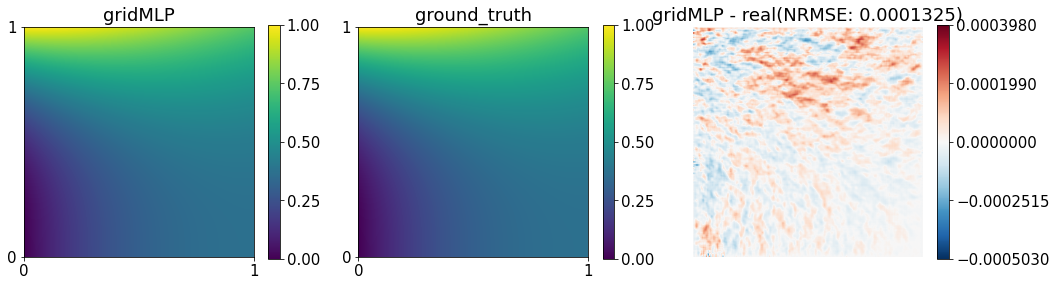

In [101]:
ifsave = False
plot_diff(pred,u_real_plot,field_name = "gridMLP",f_name = '',ifsave = ifsave)

In [102]:
# plot_result_node(f = pred_v,f0 = ground_truth_v,x = (x1,x2),mesh = tri,name = "uy",f_name = 'uy',ifsave = ifsave)

In [103]:
# #Points for plot
# resolution = 2501
# field_min,field_max = 0,1
# x1_list = np.linspace(field_min, field_max, resolution)
# x2_list = np.linspace(field_min, field_max, resolution)
# X1,X2 = np.meshgrid(x1_list,x2_list)
# X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis = 1)).float().cuda()


# in_hole = ((X_field[:,0]**2+X_field[:,1]**2-r_hole**2)<=0).to('cpu').numpy().reshape(resolution,resolution)
# disp_x = modelu(X_field)
# disp_x = disp_x.to('cpu').detach().numpy().reshape(resolution,resolution)


# dux_dx = np.diff(disp_x)*(resolution-1)
# dux_dx[in_hole[:,:-1]] = 0

# X1_diffx = torch.tensor(X1[:,:-1]+1/(resolution-1)/2)
# X2_diffx = torch.tensor(X2[:,:-1])
# real_exx = domain.strain_tensor(X1_diffx,X2_diffx)[0].numpy()
# real_exx[in_hole[:,:-1]] = 0

In [104]:
# disp_y = modelv(X_field)
# disp_y = disp_y.to('cpu').detach().numpy().reshape(resolution,resolution)


# duy_dy = np.diff(disp_y,axis = 0)*(resolution-1)
# duy_dy[in_hole[:-1,:]] = 0

# X1_diffy = torch.tensor(X1[:-1,:])
# X2_diffy = torch.tensor(X2[:-1,:]+1/(resolution-1)/2)
# real_eyy = domain.strain_tensor(X1_diffy,X2_diffy)[1].numpy()
# real_eyy[in_hole[:-1,:]] = 0

In [105]:
# ifsave_FDM = False
# plot_diff(dux_dx,real_exx,"exx_FDM","diff_exx_fdm",ifsave = ifsave_FDM)

In [106]:
# plot_diff(duy_dy,real_eyy,"eyy_FDM","diff_eyy_fdm",ifsave = ifsave_FDM)

In [107]:
# disp_y = modelv(X_field)
# # disp_y[(X_field[:,0]**2+X_field[:,1]**2-r_hole**2)<=0] = 0
# disp_y = disp_y.to('cpu').detach().numpy().reshape(resolution,resolution)
# duy_dy = np.diff(disp_y,axis = 0)*(resolution-1)
# duy_dy[in_hole[:-1,:]] = 0
# plt.imshow(duy_dy,origin = 'lower',vmin = -0.1,vmax = 0.01)
# plt.colorbar()
# plt.title("eyy_finite_diff")
# plt.savefig('figs/eyy_finite_diff.jpg', dpi = 500)

In [108]:
# ifsave = False
# plot_diff(u_plot,ground_truth_u_plot,"ux","diff_ux_gridsample",ifsave = ifsave)

In [109]:
# plot_diff(v_plot,ground_truth_v_plot,"uy","diff_uy_gridsample",ifsave = ifsave)

In [110]:
# X1_autodiff = torch.tensor(X1[:-1,:-1]+1/(resolution-1)/2)
# X2_autodiff = torch.tensor(X2[:-1,:-1]+1/(resolution-1)/2)
# in_hole_autodiff = ((X1_autodiff**2+X2_autodiff**2-r_hole**2)<=0).to('cpu').numpy().reshape(resolution-1,resolution-1)

# X_IP = torch.cat((X1_autodiff.reshape(-1,1),X2_autodiff.reshape(-1,1)),axis = 1).float().cuda()

# point_num = X_IP.shape[0]
# pred_e11_IP = np.zeros(point_num)
# pred_e12_IP = np.zeros(point_num)
# pred_e22_IP = np.zeros(point_num)
# plot_batch_size = 100000

# # diff_info_plot = grad1(model, plot_batch_size)
# i_batch = 0
# i_1 = 0
# for X_plot_batch in X_IP.split(plot_batch_size):
#     i_1 = i_batch+X_plot_batch.shape[0]
#     e11_IP,e12_IP = diff_info_u.forward_2d_plot(X_plot_batch)
#     e21_IP,e22_IP = diff_info_v.forward_2d_plot(X_plot_batch)
#     # e11_IP,e12_IP,e21_IP,e22_IP =diff_info_plot.forward_2d_uv_plot(X_plot_batch)

#     e11_IP = e11_IP.to('cpu').detach().numpy()
#     e22_IP = e22_IP.to('cpu').detach().numpy()
#     e12_IP = ((e12_IP+e21_IP)/2).to('cpu').detach().numpy()
    
#     pred_e11_IP[i_batch:i_1] = e11_IP
#     pred_e12_IP[i_batch:i_1] = e12_IP
#     pred_e22_IP[i_batch:i_1] = e22_IP
    
#     i_batch = i_1
#     print(i_batch,point_num)
    
# # rmse_e11 = my_rmse(pred_e11_IP, true_e11_IP)
# # rmse_e22 = my_rmse(pred_e22_IP, true_e22_IP)
# # rmse_e12 = my_rmse(pred_e12_IP, true_e12_IP)

# # rmse_e11 = float(np.format_float_positional(rmse_e11,precision = 3,unique=False, fractional=False, trim='k'))
# # rmse_e22 = float(np.format_float_positional(rmse_e22,precision = 3,unique=False, fractional=False, trim='k'))
# # rmse_e12 = float(np.format_float_positional(rmse_e12,precision = 3,unique=False, fractional=False, trim='k'))

# # x1 = np.loadtxt(real_path + "x1_plot.txt")
# # x2 = np.loadtxt(real_path + "x2_plot.txt")
# # tri = np.loadtxt(real_path + "tri_plot.txt")

In [111]:

# # e11_IP,e12_IP = diff_info_u.forward_2d_plot(X_IP)
# # e21_IP,e22_IP = diff_info_v.forward_2d_plot(X_IP)

# # pred_e11_IP = e11_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)
# # pred_e22_IP = e22_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)
# # pred_e12_IP = ((e12_IP+e21_IP)/2).to('cpu').detach().numpy().reshape(resolution-1,resolution-1)


# pred_e11_IP = pred_e11_IP.reshape(resolution-1,resolution-1)
# pred_e22_IP = pred_e22_IP.reshape(resolution-1,resolution-1)
# pred_e12_IP = pred_e12_IP.reshape(resolution-1,resolution-1)

# pred_e11_IP[in_hole_autodiff] = 0
# pred_e22_IP[in_hole_autodiff] = 0
# pred_e12_IP[in_hole_autodiff] = 0

# true_e11_IP,true_e22_IP,true_e12_IP = domain.strain_tensor(X_IP[:,0],X_IP[:,1])
# true_e11_IP = true_e11_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)
# true_e22_IP = true_e22_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)
# true_e12_IP = true_e12_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)

# true_e11_IP[in_hole_autodiff] = 0
# true_e22_IP[in_hole_autodiff] = 0
# true_e12_IP[in_hole_autodiff] = 0

In [112]:
# ifsave = False
# plot_diff(pred_e11_IP,true_e11_IP,"exx_autodiff","diff_exx_autodiff",ifsave = ifsave)

In [113]:
# plot_diff(pred_e22_IP,true_e22_IP,"eyy_autodiff","diff_eyy_autodiff",ifsave = ifsave)

In [114]:
# IP_x = np.loadtxt(real_path + "IP_x.txt")
# IP_y = np.loadtxt(real_path + "IP_y.txt")
# X_nodes = torch.tensor(np.concatenate([IP_x.reshape(-1,1),IP_y.reshape(-1,1)]
#                                    ,axis = 1)).float().cuda()

In [115]:
# e11_nodes,e12_nodes = diff_info_u.forward_2d_plot(X_nodes)
# e21_nodes,e22_nodes = diff_info_v.forward_2d_plot(X_nodes)

# pred_e11_nodes = e11_nodes.to('cpu').detach().numpy()
# pred_e22_nodes = e22_nodes.to('cpu').detach().numpy()
# pred_e12_nodes = ((e12_nodes+e21_nodes)/2).to('cpu').detach().numpy()

# true_e11_nodes,true_e22_nodes,true_e12_nodes = domain.strain_tensor(X_nodes[:,0],X_nodes[:,1])
# true_e11_nodes = true_e11_nodes.to('cpu').detach().numpy()
# true_e22_nodes = true_e22_nodes.to('cpu').detach().numpy()
# true_e12_nodes = true_e12_nodes.to('cpu').detach().numpy()

In [116]:
# ifsave = False
# plot_result_ele(f = pred_e11_nodes,f0 = true_e11_nodes,x = (x1,x2),mesh = tri,name = "exx",f_name = 'exx',ifsave = ifsave)

In [117]:
# plot_result_ele(f = pred_e12_nodes,f0 = true_e12_nodes,x = (x1,x2),mesh = tri,name = "exy",f_name = 'exy',ifsave = ifsave)

In [118]:
# plot_result_ele(f = pred_e22_nodes,f0 = true_e22_nodes,x = (x1,x2),mesh = tri,name = "eyy",f_name = 'eyy',ifsave = ifsave)

In [119]:
# modelu.eval()
# modelv.eval()
# torch.no_grad()
# resolution = 501
# eps = boundary_min
# field_min,field_max = eps,1-eps
# x1_list = np.linspace(field_min, field_max, resolution)
# x2_list = np.linspace(field_min, field_max, resolution)
# X1,X2 = np.meshgrid(x1_list,x2_list)
# X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis = 1)).float().cuda()

# plot_batch = X_field.shape[0]
# diff_info_u = grad1(modelu, plot_batch)
# diff_info_v = grad1(modelv, plot_batch)
# u_x,u_y = diff_info_u.forward_2d(X_field)
# v_x,v_y = diff_info_v.forward_2d(X_field)
# ux_plot = u_x.to('cpu').detach().numpy().reshape(resolution,resolution)
# vy_plot = v_y.to('cpu').detach().numpy().reshape(resolution,resolution)
# tao_xy_plot = (0.5*(u_y.detach()+v_x.detach())).to('cpu').numpy().reshape(resolution,resolution)

In [120]:
# plt.figure(figsize=(16,4))

# plt.subplot(131)
# fmax = float(np.format_float_positional(ux_plot.max(),precision = 3,unique=False, fractional=False, trim='k'))
# fmin = float(np.format_float_positional(ux_plot.min(),precision = 3,unique=False, fractional=False, trim='k'))
# interval = (fmax-fmin)/4
# ct = (fmin, fmin + interval, fmin + 2*interval, fmin + 3*interval, fmax)
# plt.imshow(ux_plot,origin = 'lower',norm=colors.TwoSlopeNorm(vcenter=ct[2],vmin = ct[0],vmax = ct[-1]),
#           interpolation = None)
# # plt.imshow(f_plot,origin = 'lower',interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.colorbar(ticks=ct)
# plt.axis('off')
# plt.title('exx (rmse:{})'.format(rmse_e11))

# plt.subplot(132)
# fmax = float(np.format_float_positional(vy_plot.max(),precision = 3,unique=False, fractional=False, trim='k'))
# fmin = float(np.format_float_positional(vy_plot.min(),precision = 3,unique=False, fractional=False, trim='k'))
# interval = (fmax-fmin)/4
# ct = (fmin, fmin + interval, fmin + 2*interval, fmin + 3*interval, fmax)
# plt.imshow(vy_plot,origin = 'lower',norm=colors.TwoSlopeNorm(vcenter=ct[2],vmin = ct[0],vmax = ct[-1]),
#           interpolation = None)
# # plt.imshow(f_plot,origin = 'lower',interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.colorbar(ticks=ct)
# plt.axis('off')
# plt.title('eyy (rmse:{})'.format(rmse_e22))

# plt.subplot(133)
# fmax = float(np.format_float_positional(tao_xy_plot.max(),precision = 3,unique=False, fractional=False, trim='k'))
# fmin = float(np.format_float_positional(tao_xy_plot.min(),precision = 3,unique=False, fractional=False, trim='k'))
# interval = (fmax-fmin)/4
# ct = (fmin, fmin + interval, fmin + 2*interval, fmin + 3*interval, fmax)
# plt.imshow(tao_xy_plot,origin = 'lower',norm=colors.TwoSlopeNorm(vcenter=ct[2],vmin = ct[0],vmax = ct[-1]),
#           interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.colorbar(ticks=ct)
# plt.axis('off')
# plt.title('exy (rmse:{})'.format(rmse_e12))
# fig.tight_layout()
# # plt.savefig('figs/fiber_eps_2grid.jpg',dpi = 300)
# plt.show()

In [121]:
# np.savetxt("results_data/tinyfix_w50.txt", f_plot)

In [122]:
# n_plots = 6
# torch.no_grad()
# field_y = encoding_v(X_field.to(device)).to('cpu').detach().numpy()
# plot_levels = np.linspace(0,n_levels-1,n_plots).astype('int')
# plt.figure(figsize=(14,8))

# for level,i in zip(plot_levels,range(n_plots)):
#     plt.subplot(2,3,i+1)
#     f_plot = field_y[:,level*n_features].reshape(resolution,resolution)
#     fmax = f_plot.max()
#     fmin = f_plot.min()
#     interval = (fmax-fmin)/4
#     ct = (my_sig(fmin,2), my_sig(fmin + interval,2), my_sig(fmin + 2*interval,2), my_sig(fmin + 3*interval,2), my_sig(fmax,2))    
#     plt.imshow(f_plot,origin = 'lower',interpolation = None,vmin=my_sig(fmin,2), vmax=my_sig(fmax,2))

#     plt.xticks([0,resolution],[0,1])
#     plt.yticks([0,resolution],[0,1])
#     plt.axis('off')
#     res = np.floor(np.power(p_l_s, float(level), dtype="d")*base_res-1, dtype="d").astype(int)+1
#     plt.title("level = {}, res = {}".format(level+1,res))
#     plt.colorbar(ticks=ct)

# # plt.savefig('figs/feature_output.jpg',dpi = 1500)
# plt.show()

In [123]:
# n_plots = 6
# X_field_grad = X_field.to(device).clone()
# X_field_grad.requires_grad = True
# field_y = encoding_v(X_field_grad)
# plot_levels = np.linspace(0,n_levels-1,n_plots).astype('int')
# plt.figure(figsize=(14,8))

# for level,i in zip(plot_levels,range(n_plots)):
#     plt.subplot(2,3,i+1)
#     f_plot_disp = field_y[:,level*n_features]#.reshape(resolution,resolution)
#     f_plot = grad(f_plot_disp,X_field_grad,
#                        torch.ones_like(f_plot_disp).to(device),
#                        retain_graph=True, create_graph=True)[0][:,1].reshape(resolution,resolution).to('cpu').detach().numpy()[1:-1,1:-1]
#     fmax = f_plot.max()
#     fmin = f_plot.min()
#     interval = (fmax-fmin)/4
#     ct = (my_sig(fmin,2), my_sig(fmin + interval,2), my_sig(fmin + 2*interval,2), my_sig(fmin + 3*interval,2), my_sig(fmax,2))    
#     plt.imshow(f_plot,origin = 'lower',interpolation = None,vmin=my_sig(fmin,2), vmax=my_sig(fmax,2))

# #     plt.xticks([0,resolution],[xmin,xmax])
# #     plt.yticks([0,resolution],[ymin,ymax])
#     plt.axis('off')
#     res = np.floor(np.power(p_l_s, float(level), dtype="d")*base_res-1, dtype="d").astype(int)+1
#     plt.title("level = {}, res = {}".format(level+1,res))
#     plt.colorbar(ticks=ct)

# plt.show()

In [124]:
# n_plots = 6
# X_field_grad = X_field.to(device).clone()
# X_field_grad.requires_grad = True
# f_plot_feature = encoding_u(X_field_grad)
# f_plot_disp = mlp(f_plot_feature)
# f_plot_all = grad(f_plot_disp,f_plot_feature,
#                    torch.ones_like(f_plot_disp).to(device),
#                    retain_graph=True, create_graph=True)[0]
# plot_levels = np.linspace(0,n_levels-1,n_plots).astype('int')
# plt.figure(figsize=(14,8))

# for level,i in zip(plot_levels,range(n_plots)):
#     plt.subplot(2,3,i+1)    
#     f_plot = f_plot_all[:,level*n_features].reshape(resolution,resolution).to('cpu').detach().numpy()
#     fmax = f_plot.max()
#     fmin = f_plot.min()
#     interval = (fmax-fmin)/4
#     ct = (my_sig(fmin,2), my_sig(fmin + interval,2), my_sig(fmin + 2*interval,2), my_sig(fmin + 3*interval,2), my_sig(fmax,2))    
#     plt.imshow(f_plot,origin = 'lower',interpolation = None,vmin=my_sig(fmin,2), vmax=my_sig(fmax,2))

#     plt.xticks([0,resolution],[xmin,xmax])
#     plt.yticks([0,resolution],[ymin,ymax])
#     plt.axis('off')
#     res = np.floor(np.power(p_l_s, float(level), dtype="d")*base_res-1, dtype="d").astype(int)+1
#     plt.title("level = {}, res = {}".format(level+1,res))
#     plt.colorbar(ticks=ct)

# plt.show()
# f_plot_all.to('cpu').detach().numpy().mean(axis = 0)

In [125]:
# n_plots = 6
# X_field_grad = X_field.to(device).clone()
# X_field_grad.requires_grad = True

# f_plot_feature = encoding_u(X_field_grad)
# f_plot_disp = mlp(f_plot_feature)
# dm_dh = grad(f_plot_disp,f_plot_feature,
#                    torch.ones_like(f_plot_disp).to(device),
#                    retain_graph=True, create_graph=True)[0].to('cpu').detach()
# dh_dx1 = torch.zeros_like(dm_dh)
# for level in range(n_plots):
#     dhi_dx1 = grad(f_plot_feature[:,level],X_field_grad,
#                        torch.ones_like(f_plot_feature[:,level]).to(device),
#                        retain_graph=True, create_graph=True)[0][:,0].to('cpu').detach()
#     dh_dx1[:,level] = dhi_dx1

# f_plot = (dm_dh*dh_dx1).sum(axis = 1).reshape(resolution,resolution).numpy()

# plt.figure(figsize=(6,6))

# fmax = f_plot.max()
# fmin = f_plot.min()
# interval = (fmax-fmin)/4
# ct = (my_sig(fmin,2), my_sig(fmin + interval,2), my_sig(fmin + 2*interval,2), my_sig(fmin + 3*interval,2), my_sig(fmax,2))    
# plt.imshow(f_plot,origin = 'lower',interpolation = None,vmin=my_sig(fmin,2), vmax=my_sig(fmax,2))

# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.axis('off')
# plt.colorbar(ticks=ct)

# plt.show()

In [126]:
# target_level = 12
# # encoding.eval()
# torch.no_grad()
# field_y = encoding_u(X_field.to(device)).to('cpu').detach().numpy()
# plt.figure(figsize=(10,8))
# if target_level != 0:
#     plt.subplot(2,2,1)
#     f_plot = field_y[:,target_level*n_features - 1].reshape(resolution,resolution)
#     plt.imshow(f_plot,origin = 'lower',interpolation = None)
#     plt.xticks([0,resolution],[xmin,xmax])
#     plt.yticks([0,resolution],[ymin,ymax])
#     plt.axis('off')
#     plt.title("level = {}, F = {}".format(target_level,2))
#     plt.colorbar()

# plt.subplot(2,2,2)
# f_plot = field_y[:,target_level*n_features].reshape(resolution,resolution)
# plt.imshow(f_plot,origin = 'lower',interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.axis('off')
# plt.title("level = {}, F = {}".format(target_level+1,1))
# plt.colorbar()
# plt.subplot(2,2,3)
# f_plot = field_y[:,(target_level+1)*n_features -1].reshape(resolution,resolution)
# plt.imshow(f_plot,origin = 'lower',interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.axis('off')
# plt.title("level = {}, F = {}".format(target_level+1,2))
# plt.colorbar()
# if target_level != n_levels-1:
#     plt.subplot(2,2,4)
#     f_plot = field_y[:,(target_level+1)*n_features].reshape(resolution,resolution)
#     plt.imshow(f_plot,origin = 'lower',interpolation = None)
#     plt.xticks([0,resolution],[xmin,xmax])
#     plt.yticks([0,resolution],[ymin,ymax])
#     plt.axis('off')
#     plt.title("level = {}, F = {}".format(target_level+2,1))
#     plt.colorbar()

# plt.show()